# Sample Tree Locations

This notebook generates a random sample of point locations across the Sierras and extracts a series of raster values at each location. We'll use this data to understand the distributions of height values and the proportional area of each vegetation type across the ecoregion.

### Packages, paths, preferences & functions

In [19]:
# packages
import os
import artlo
from artlo import plt
import numpy as np
import pandas as pd
import geopandas as gpd
import elapid as ela
from scipy.stats import gaussian_kde

In [2]:
# paths
base = '/home/cba/src/cfo-big-trees'
data = os.path.join(base, 'data')
vector = os.path.join(data, 'vector')
raster = os.path.join(data, 'raster')
plots = os.path.join(base, 'docs', 'img')

sierra_poly = os.path.join(vector, 'sierra-ecoregion.gpkg')
height_raster = os.path.join(raster, 'SierraEcoregion-Vegetation-CanopyHeight-2020-Summer-00010m.tif')
class_raster = os.path.join(raster, 'SierraEcoregion-Vegetation-Classes-2020-Summer-00030m.tif')
class_labels = os.path.join(raster, 'us_140esp_accel_reclass_wRAT.tif.vat.dbf')
output_samples = os.path.join(vector, 'point-samples-all.gpkg')

# preferences
artlo.plot.set_style('salo-light')

In [3]:
# frequency distributions plotting routine
def density_dist(ydata,plot=None,fill=True,fill_alpha=0.3,label=None,linewidth=2,xlabel=None,
                 ylabel="Relative Frequency",xlim=None,ylim=None,covar=0.25,cutoff=2,**kwargs,
):
    # handle uneven sample sizes
    if type(ydata) is list:
        ncol = len(ydata)

    # handle numpy arrays
    elif type(ydata) is np.ndarray:
        # if the ndarray is only 1-d, convert it to a list
        if ydata.ndim == 1:
            ydata = [ydata]
        # otherwise, loop through each column and assign as unique items in list
        else:
            newdata = []
            for i in range(ydata.shape[1]):
                newdata.append(ydata[:, i])
            ydata = newdata
        ncol = len(ydata)
    else:
        print("[ ERROR ]: unsupported ydata format. must be a list or np.ndarray")

    if not plot:
        plot = plt

    # handle labels
    if label is not None:
        if type(label) is str:
            label = list(label)
        else:
            if len(label) < ncol:
                print("[ ERROR ]: number of labels specified doesn't match number of columns")
                label = []
                for i in range(ncol):
                    label.append(None)
    else:
        label = []
        for i in range(ncol):
            label.append(None)

    # find the min/max range for plot based on %cutoff
    if not xlim:
        xmin = []
        xmax = []
        for i in range(ncol):
            xmin.append(np.percentile(np.array(ydata[i]), cutoff))
            xmax.append(np.percentile(np.array(ydata[i]), 100 - cutoff))
        xlim = [min(xmin), max(xmax)]

    # set the x plot size
    xs = np.linspace(xlim[0], xlim[1])

    # loop through each feature, calculate the covariance, and plot
    for i in range(ncol):
        dns = gaussian_kde(np.array(ydata[i]))
        dns.covariance_factor = lambda: covar
        dns._compute_covariance()
        ys = dns(xs)

        # plotting functions
        plot.plot(xs, ys, label=label[i], linewidth=linewidth, **kwargs)
        if fill:
            plot.fill_between(xs, ys, alpha=fill_alpha)

    # finalize other meta plot routines
    plot.xlabel(xlabel)
    plot.ylabel(ylabel)
    if label[0] is not None:
        plot.legend()
    plot.tight_layout()

    # return the final object object for further manipulation
    return plot

### Dataset creation

In [4]:
# set this to True to run the sample generation / annotation from scratch. if False, read from disk.
rerun = False

if rerun:
    # create a random geographic sample across the full ecoregion extent
    n_samples = 200_000
    sample_pts = ela.sample_vector(sierra_poly, count=n_samples)
    
    # extract values from each raster dataset
    annotated = ela.annotate(
        sample_pts,
        [height_raster, class_raster],
        labels=['height', 'vegtype'],
        drop_na=True
    )
    
    # filter improperly masked datasets (values with 255 are nodata in the veg type raster)
    valid = annotated['vegtype'] != 255
    annotated = annotated[valid].reset_index(drop=True)

    # save the data to disk for later use
    annotated.to_file(output_samples, driver='GPKG')
    
else:
    annotated = gpd.read_file(output_samples)
    
print(annotated.head())

   height  vegtype                        geometry
0       5       12  POINT (797765.751 4220778.048)
1       2       11  POINT (805637.230 4180067.203)
2      16       11  POINT (711543.103 4279275.472)
3       2        8  POINT (870632.581 4160811.113)
4      12       12  POINT (770334.174 4276891.735)


In [8]:
# construct a set of labels for each class to plot
unique_classes = list(annotated['vegtype'].unique())
unique_classes.sort()

class_labels_df = gpd.read_file(class_labels)
labels = {}
for _, row in class_labels_df.iterrows():
    cls = int(row['VALUE'])
    if cls in unique_classes:
        vegclass = row['vegclass']
        if vegclass not in ['shrub', 'grass']:
            labels[cls] = row['vegclass']

# and a set of human-readable labels for figure plotting
plot_labels = {
    "riparian": "Riparian forests",
    "low_elev_woodland": "Low elevation woodlands",
    "hi_elev_woodland": "High elevation woodlands",
    "pipo_jeff": "Ponderosa & Jeffrey Pine",
    "mid_elev_conifer": "Mid elevation conifers",
    "high_elev_conifer": "High elevation conifers",
}

### Analysis

In [17]:
# print summary stats on the tree data for each class
heights = []
for vegtype, veglabel in labels.items():
    idxs = annotated['vegtype'] == vegtype
    sub = annotated[idxs].reset_index(drop=True)
    trees_idx = sub['height'] >= 5
    trees = sub[trees_idx]['height']
    pct_trees = 100 * (trees_idx.sum() / len(sub))
    pct95 = np.percentile(trees, 95)
    pct50 = np.percentile(trees, 50)
    heights.append(trees)
    print(f"{plot_labels[veglabel]:25s} | {pct_trees:0.2f} (% tree cover) | {pct50:05.2f} (median height) | {pct95:0.2f} (95% height)")

Riparian forests          | 81.23 (% tree cover) | 15.00 (median height) | 32.00 (95% height)
Low elevation woodlands   | 53.41 (% tree cover) | 10.00 (median height) | 24.00 (95% height)
High elevation woodlands  | 22.45 (% tree cover) | 07.00 (median height) | 15.00 (95% height)
Ponderosa & Jeffrey Pine  | 50.28 (% tree cover) | 10.00 (median height) | 20.00 (95% height)
Mid elevation conifers    | 81.66 (% tree cover) | 16.00 (median height) | 32.00 (95% height)
High elevation conifers   | 68.50 (% tree cover) | 12.00 (median height) | 24.00 (95% height)


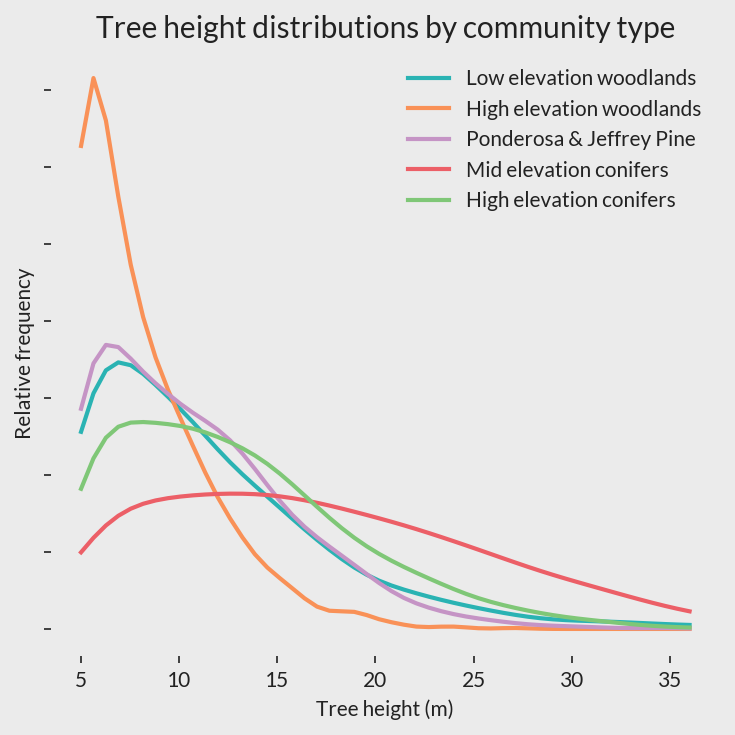

In [36]:
# plot the frequency distributions by veg type, skipping the Riparian class
label = [val for key, val in plot_labels.items()]
plt.figure(figsize=(5,5), dpi=150)
plt = density_dist(heights[1:], plot=plt, label=label[1:], xlabel='Tree height (m)', ylabel='Relative frequency', fill_alpha=0)
plt.tick_params(labelleft=False)
plt.title("Tree height distributions by community type")
plt.tight_layout()
plt.savefig(os.path.join(plots, 'height-by-vegclass.png'), dpi=200, transparent=True)

## Diameter distribution plotting

In [21]:
all_diams = pd.read_csv(os.path.join(vector, 'diamDist_lrgTreeHeight30m_all.csv'))
grp_diams = pd.read_csv(os.path.join(vector, 'diamDist_lrgTreeHeightVaryByVegType_all.csv'))

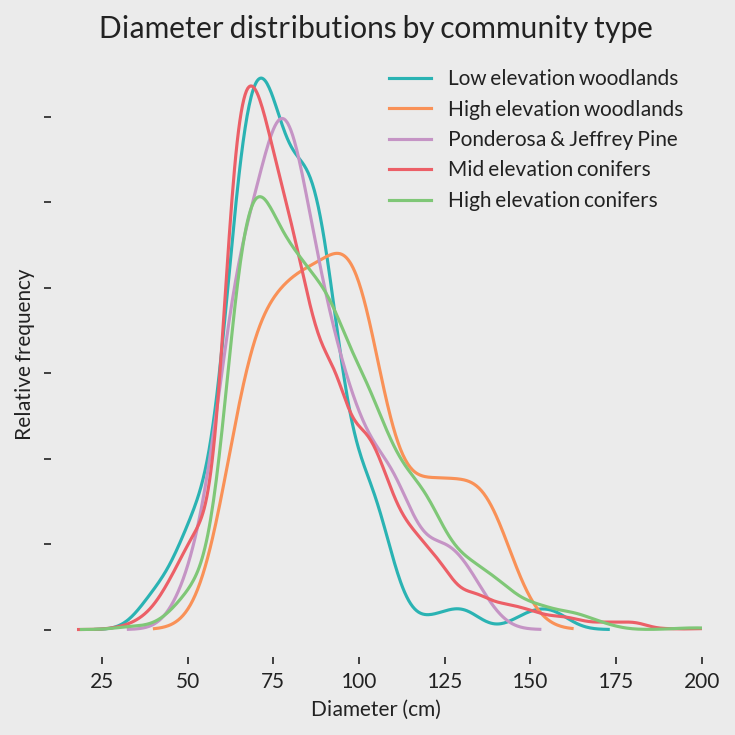

In [46]:
# plot all diameters first
df = all_diams
plt.figure(figsize=(5,5), dpi=150)
for vegtype, veglabel in labels.items():
    if veglabel == "riparian":
        continue
    idxs = df['esp'] == veglabel
    sub = df[idxs].reset_index(drop=True)
    plt.plot(sub['x']*2.54, sub['y'], label=plot_labels[veglabel])

plt.title("Diameter distributions by community type")
plt.xlabel('Diameter (cm)')
plt.ylabel("Relative frequency")
plt.legend(loc='upper right')
plt.tick_params(labelleft=False)
plt.xlim(10, 200)
plt.tight_layout()
plt.savefig(os.path.join(plots, 'diameter-by-vegclass-ecoregion.png'), dpi=200, transparent=True)

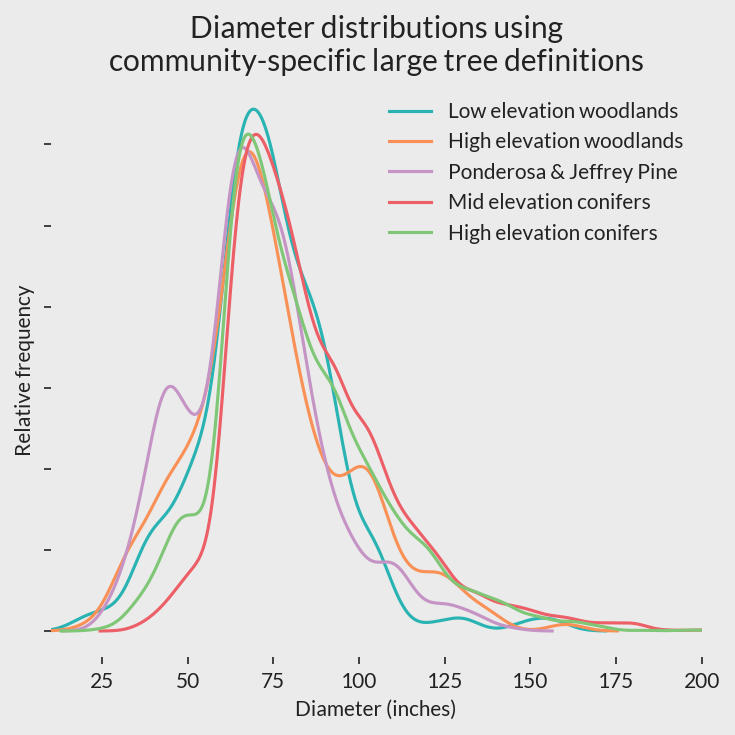

In [45]:
# using community-based height cutoffs
df = grp_diams
plt.figure(figsize=(5,5), dpi=150)
for vegtype, veglabel in labels.items():
    if veglabel == "riparian":
        continue
    idxs = df['esp'] == veglabel
    sub = df[idxs].reset_index(drop=True)
    plt.plot(sub['x']*2.54, sub['y'], label=plot_labels[veglabel])

plt.title("Diameter distributions using\ncommunity-specific large tree definitions")
plt.xlabel('Diameter (inches)')
plt.ylabel("Relative frequency")
plt.legend(loc='upper right')
plt.tick_params(labelleft=False)
plt.xlim(10, 200)
plt.tight_layout()
plt.savefig(os.path.join(plots, 'diameter-by-vegclass-community.png'), dpi=200, transparent=True)